## 01_ETL

Description ...

In [1]:
import ast
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
from lib import personalised_graphics, transformations

##### steam_games dataset

Import and explore

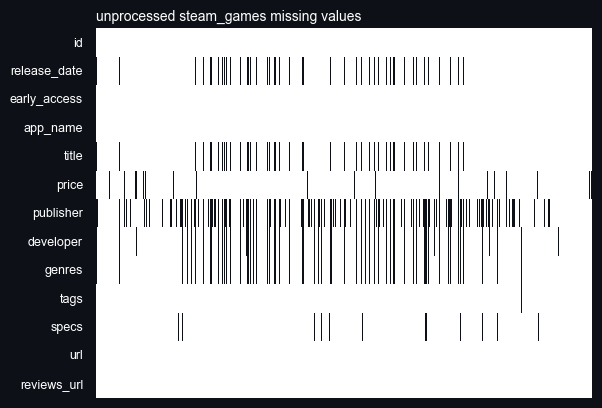

,id,release_date,early_access,app_name,title,price,publisher,developer,genres,tags,specs,url,reviews_url
88310,761140.0,2018-01-04,0.0,Lost Summoner Kitty,Lost Summoner Kitty,4.99,Kotoshiro,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],http://store.steampowered.com/app/761140/Lost_...,http://steamcommunity.com/app/761140/reviews/?...
88311,643980.0,2018-01-04,0.0,Ironbound,Ironbound,Free To Play,"Making Fun, Inc.",Secret Level SRL,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",http://store.steampowered.com/app/643980/Ironb...,http://steamcommunity.com/app/643980/reviews/?...
88312,670290.0,2017-07-24,0.0,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Free to Play,Poolians.com,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",http://store.steampowered.com/app/670290/Real_...,http://steamcommunity.com/app/670290/reviews/?...
88313,767400.0,2017-12-07,0.0,弹炸人2222,弹炸人2222,0.99,彼岸领域,彼岸领域,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],http://store.steampowered.com/app/767400/2222/,http://steamcommunity.com/app/767400/reviews/?...
88314,773570.0,None,0.0,Log Challenge,None,2.99,None,None,None,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",http://store.steampowered.com/app/773570/Log_C...,http://steamcommunity.com/app/773570/reviews/?...


In [2]:
# Import dataset
steam_games = pd.read_json('data/unprocessed/output_steam_games.json', lines=True)
steam_games = steam_games.dropna(how='all')

# Reorder columns
steam_games = steam_games[['id', 'release_date', "early_access", 'app_name', "title", 'price', 'publisher', 'developer', "genres", 'tags', 'specs', "url", "reviews_url"]]

# Explore
personalised_graphics.missing_values_heatmap(steam_games, "unprocessed steam_games")
steam_games.head(5)

Transform

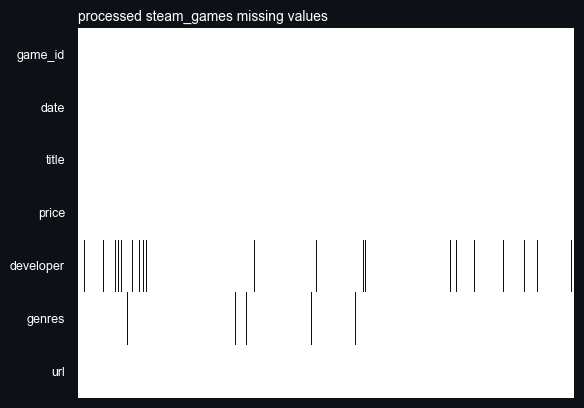

In [3]:
# Drop unrelevant data
steam_games.drop(columns=['early_access', 'reviews_url'], inplace=True)

# Handle missing values
steam_games.at[90890, "app_name"] = "Duet"
steam_games.dropna(subset=["app_name"], inplace=True)
genres = []
for i, row in steam_games.iterrows():
    if row["tags"] == None and row["genres"] != None:
        genres.append(row["genres"])
    else:
        genres.append(row["tags"])
steam_games["tags"] = genres
steam_games["price"].fillna(0, inplace=True)

# Handle wrong price datatypes
steam_games["int_price"] = 0
errors = []
for i, row in steam_games.iterrows():
    try:
        row["int_price"] = float(row["price"])
    except ValueError:
        errors.append(row["price"])
errors = [value for value in set(errors)]
steam_games["price"].replace("Starting at $499.00", 500, inplace=True)
errors.remove("Starting at $499.00")
steam_games["price"].replace("Starting at $449.00", 450, inplace=True)
errors.remove("Starting at $449.00")
for error in errors:
    steam_games["price"].replace(error, 0, inplace=True)
steam_games['price'] = steam_games['price'].astype(float)
steam_games.drop(columns=["int_price"], inplace=True)
steam_games['release_date'] = pd.to_datetime(steam_games['release_date'], errors='coerce')

# Drop repetitive columns
steam_games.drop(columns=['title', 'genres', 'publisher', 'specs'], inplace=True)

# Restructure dataframe
steam_games.rename(columns={"id": "game_id" ,"release_date": "date", "app_name": "title", "tags": "genres"}, inplace=True)
steam_games = steam_games.sort_values(by='date')
steam_games.dropna(subset=['date'], inplace=True)
steam_games = steam_games.reset_index(drop=True)

# Show
personalised_graphics.missing_values_heatmap(steam_games, "processed steam_games")

Export

In [4]:
steam_games.to_csv("data/processed/steam_games.csv")

##### australian_users_reviews dataset

Import and explore

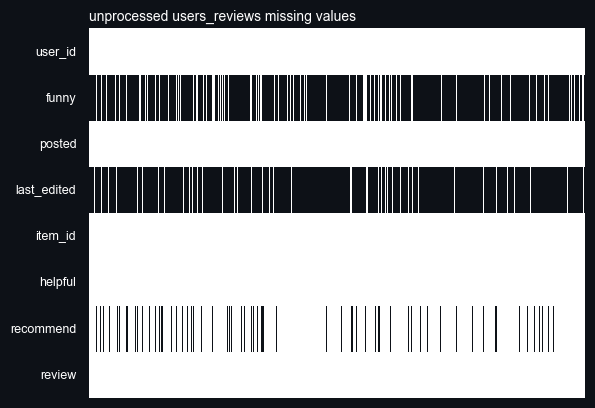

,user_id,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,None,"Posted November 5, 2011.",None,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,None,"Posted July 15, 2011.",None,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,None,"Posted April 21, 2011.",None,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,None,"Posted June 24, 2014.",None,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,None,"Posted September 8, 2013.",None,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


In [5]:
# Import dataset
rows=[]
with open('data/unprocessed/australian_user_reviews.json', encoding='MacRoman') as file:
    for line in file.readlines():
        rows.append(ast.literal_eval(line))
users_reviews = pd.DataFrame(rows)

# Desanidate columns
reviews = []
for index, row in users_reviews.iterrows():
    user_id = row['user_id']
    reviews_list = row['reviews']
    for review_dict in reviews_list:
        funny = review_dict['funny']
        posted = review_dict['posted']
        last_edited = review_dict['last_edited']
        item_id = review_dict['item_id']
        helpful = review_dict['helpful']
        recommend = review_dict['recommend']
        review = review_dict['review']
        if not funny:
            funny = None
        if not posted:
            posted = None
        if not last_edited:
            last_edited = None
        if not item_id:
            item_id = None
        if not helpful:
            helpful = None
        if not recommend:
            recommend = None
        if not review:
            review = None
        reviews.append({'user_id': user_id, 'funny': funny, 'posted': posted, 'last_edited': last_edited, 'item_id': item_id, 'helpful': helpful, 'recommend': recommend, 'review': review})
users_reviews = pd.DataFrame(reviews)

# Explore
personalised_graphics.missing_values_heatmap(users_reviews, "unprocessed users_reviews")
users_reviews.head(5)

Transform and explore

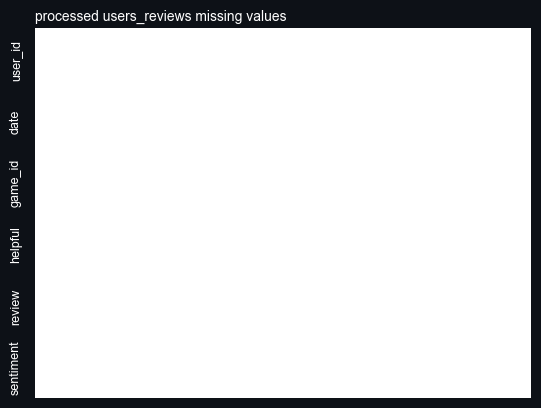

,user_id,date,game_id,helpful,review,sentiment
0,76561197970982479,2011-11-05 00:00:00,1250,No ratings yet,Simple yet with great replayability. In my opi...,1
1,76561197970982479,2011-07-15 00:00:00,22200,No ratings yet,It's unique and worth a playthrough.,2
2,76561197970982479,2011-04-21 00:00:00,43110,No ratings yet,Great atmosphere. The gunplay can be a bit chu...,1
3,js41637,2014-06-24 00:00:00,251610,15 of 20 people (75%) found this review helpful,I know what you think when you see this title ...,1
4,js41637,2013-09-08 00:00:00,227300,0 of 1 people (0%) found this review helpful,For a simple (it's actually not all that simpl...,1


In [6]:
# Create sentimment review column
users_reviews["sentiment"] = None
for index, row in users_reviews.iterrows():
    review = row['review']
    sentiment = transformations.return_sentiment(review) # This function takes a review in string format and return 2 (good), 1 (neutral), 0 (bad)
    users_reviews.at[index, 'sentiment'] = sentiment

# Transform posted and last edited columns
for index, row in users_reviews.iterrows():
    posted_date = row['posted']
    last_edited_date = row['last_edited']
    # Unificate posted and last edited column
    if last_edited_date is not None and (posted_date is None or last_edited_date > posted_date):
        users_reviews.at[index, 'posted'] = row['last_edited']
# Drop and rename columns
users_reviews.drop(columns=["last_edited"], inplace=True)
users_reviews.rename(columns={"posted": "date"}, inplace=True)
# Process date column into datetime format
for index, row in users_reviews.iterrows():
    date_str = row['date']
    date_str = date_str.replace("Posted ", "")
    date_str = date_str.replace(".", "")
    date_str = date_str.replace(",", "")
    date_parts = date_str.split()
    if len(date_parts) == 3:
        date_obj = datetime(int(date_parts[2]), datetime.strptime(date_parts[0], '%B').month, int(date_parts[1]))
    users_reviews.at[index, 'date'] = date_obj

# Drop irrelevant data columns
users_reviews.drop(columns=["funny"], inplace=True)
users_reviews.drop(columns=["recommend"], inplace=True)

# Rename columns
users_reviews.rename(columns={"item_id": "game_id"}, inplace=True)
users_reviews["game_id"] = users_reviews["game_id"].astype(int)

# Explore
personalised_graphics.missing_values_heatmap(users_reviews, "processed users_reviews")
users_reviews.head(5)

In [7]:
# Clean helpful column
for i, row in users_reviews.iterrows():
    if row["helpful"] == "No ratings yet":
        users_reviews.at[i, "weight"] = 50
    else:
        try:
            parts = row["helpful"].split(" ")
            score = parts[4].replace("%", "").replace("(", "").replace(")", "")
            users_reviews.at[i, "weight"] = int(score)  # Convert the score to an integer if needed
        except IndexError:
            pass
users_reviews.drop(columns="helpful", inplace=True)
users_reviews["weight"] = users_reviews["weight"] * 2 / 100

##### australian_users_items dataset

Import and explore

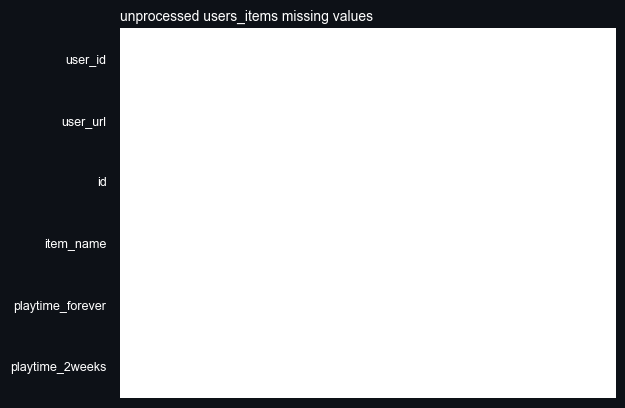

,user_id,user_url,id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6,0
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0,0
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7,0
3,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0,0
4,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0,0


In [8]:
# Import dataset
rows=[]
with open('data/unprocessed/australian_users_items.json', encoding='MacRoman') as file:
    for line in file.readlines():
        rows.append(ast.literal_eval(line))
australian_user_items = pd.DataFrame(rows)

# Desanidate column
items = []
for index, row in australian_user_items.iterrows():
    user_id = row['user_id']
    user_url = row['user_url']
    item_list = row['items']
    for item_dict in item_list:
        item_id = item_dict['item_id']
        item_name = item_dict['item_name']
        playtime_forever = item_dict['playtime_forever']
        playtime_2weeks = item_dict['playtime_2weeks']
        if not item_id:
            item_id = None
        if not item_name:
            item_name = None
        if not playtime_forever:
            playtime_forever = 0
        if not playtime_2weeks:
            playtime_2weeks = 0
        items.append({'user_id': user_id, 'user_url': user_url, 'id': item_id, 'item_name': item_name, 'playtime_forever': playtime_forever, 'playtime_2weeks': playtime_2weeks})
australian_users_items = pd.DataFrame(items)

# Explore
personalised_graphics.missing_values_heatmap(australian_users_items, "unprocessed users_items")
australian_users_items.head(5)

Transform and explore

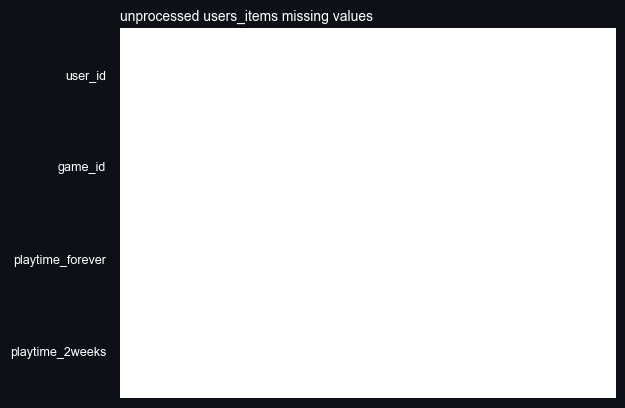

,user_id,game_id,playtime_forever,playtime_2weeks
0,76561197970982479,10,6,0
1,76561197970982479,20,0,0
2,76561197970982479,30,7,0
3,76561197970982479,40,0,0
4,76561197970982479,50,0,0


In [9]:
# Rename colums
australian_users_items.rename(columns={"id": "game_id"}, inplace=True)

# Drop unrelevant data
australian_users_items.drop(columns=["user_url", "item_name"], inplace=True)

australian_users_items["game_id"] = australian_users_items["game_id"].astype(int)

# Explore
personalised_graphics.missing_values_heatmap(australian_users_items, "unprocessed users_items")
australian_users_items.head(5)

CREATION

In [10]:
# 
users_reviews["score"] = users_reviews["sentiment"] * users_reviews["weight"]
scores = users_reviews.groupby("game_id")["score"].mean()
scores = scores.to_frame().reset_index()
scores.columns = ["game_id", "score"]
steam_games = pd.merge(steam_games, scores, on="game_id", how="left")

In [11]:
item_total_playtimes = australian_users_items.groupby("game_id")["playtime_forever"].sum()
item_total_playtimes = item_total_playtimes.to_frame().reset_index()
item_total_playtimes["game_id"] = item_total_playtimes["game_id"].astype(int)
steam_games = pd.merge(steam_games, item_total_playtimes, on="game_id", how="left")

In [12]:
item2week_playtimes = australian_users_items.groupby("game_id")["playtime_2weeks"].sum()
item2week_playtimes = item2week_playtimes.to_frame().reset_index()
item2week_playtimes["game_id"] = item2week_playtimes["game_id"].astype(int)
steam_games = pd.merge(steam_games, item2week_playtimes, on="game_id", how="left")

In [13]:
item_total_downloads = australian_users_items["game_id"].value_counts()
item_total_downloads = item_total_downloads.to_frame().reset_index()
item_total_downloads.columns = ["game_id", "downloads"]
item_total_downloads["game_id"] = item_total_downloads["game_id"].astype(int)
steam_games = pd.merge(steam_games, item_total_downloads, on="game_id", how="left")

In [60]:
# Initialize an empty list to store all unique genres
all_genres = []

# Iterate through the 'genres' column of the 'steam_games' DataFrame
for genres in steam_games['genres']:
    if genres is not None:
        for genre in genres:
            all_genres.append(genre)

# Create a DataFrame and count how many games belong to each genre
all_genres_df = pd.DataFrame(all_genres, columns=['genre'])
genre_counts = all_genres_df['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Initialize columns for classifying genres.
steam_games['popular_genres'] = None
steam_games['common_genres'] = None
steam_games['unpopular_genres'] = None

# Iterate through the 'model_data' DataFrame to classify genres
for index, row in steam_games.iterrows():
    popular_genres = []
    common_genres = []
    unpopular_genres = []
    if row['genres'] is not None:
        for genre in row['genres']:
            count = genre_counts['count'][genre_counts['genre'] == genre].values[0]
            if count >= 2500:
                popular_genres.append(genre)
            elif count >= 100:
                common_genres.append(genre)
            else:
                unpopular_genres.append(genre)
    # Assign the categorized genre lists to the respective columns
    steam_games.at[index, 'popular_genres'] = popular_genres
    steam_games.at[index, 'common_genres'] = common_genres
    steam_games.at[index, 'unpopular_genres'] = unpopular_genres

# Drop the original 'genres' column
steam_games.drop(columns='genres', inplace=True)

In [62]:
steam_games.to_csv("data/processed/steam_games.csv")